# Car Plate Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/georgia-tech-db/eva-application-template/blob/main/car_plate_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/georgia-tech-db/eva-application-template/blob/main/car_plate_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/georgia-tech-db/eva-application-template/blob/main/car_plate_detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

In [25]:
## Install Application Dependecies (Python Packages)

In [26]:
pip -q install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [27]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File '00-start-eva-server.ipynb' already there; not retrieving.

nohup eva_server > eva.log 2>&1 &

Note: you may need to restart the kernel to use updated packages.


### Load the Video for analysis

In [28]:
cursor.execute('DROP TABLE IF EXISTS MyVideos;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD VIDEO "1.mp4" INTO MyVideos;')
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                       0
0  Table Successfully dropped: MyVideos
@query_time: 0.027417619014158845
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 0.3175282250158489


### Create Custom UDF for Car Plate Detection

In [29]:
cursor.execute("DROP UDF IF EXISTS CarPlateDetector;")
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS CarPlateDetector
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (results NDARRAY FLOAT32(ANYDIM, ANYDIM))
      TYPE  Classification
      IMPL  'car_plate_detector.py';
      """) 
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                            0
0  UDF CarPlateDetector successfully dropped
@query_time: 0.01626748708076775
@status: ResponseStatus.SUCCESS
@batch: 
                                                           0
0  UDF CarPlateDetector successfully added to the database.
@query_time: 1.1445165670011193


### Run Car Plate Detector on Video

In [30]:
cursor.execute("""SELECT id, CarPlateDetector(data)
                  FROM MyVideos 
                  WHERE id < 1""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
    myvideos.id  \
0            0   

                                                                              carplatedetector.results  
0  [[0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], ...  
@query_time: 5.704022563062608


### Visualize Model Output on Video

In [31]:
from pprint import pprint
from matplotlib import pyplot as plt
import cv2
import numpy as np

def annotate_video(detections, input_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))


    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read()
    car_plates = []

    while ret:
        df = detections
        df = df[['carplatedetector.results']][df.index == frame_id]
        if df.size:
            dfList = df.values.tolist()
            mask = np.array(dfList[0][0])
            mask = mask.astype(np.uint8)

            contours, hierarchy = cv2.findContours(
                mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            plates = []

            for j, c in enumerate(contours):
                x,y,w,h = cv2.boundingRect(c)
                plate = frame[y:y+h, x:x+w]
                plates.append(plate)
                image_file_name = "frame" + str(frame_id)+ "_plate" + str(j) + ".png"
                cv2.imwrite(image_file_name, plate)
                if frame_id % 5 == 0:
                    plt.imshow(plate)
                    plt.show()

            car_plates.append(plates)
        frame_id+=1
        ret, frame = vcap.read()
    return car_plates


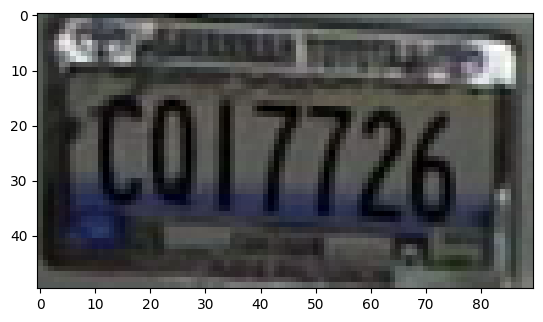

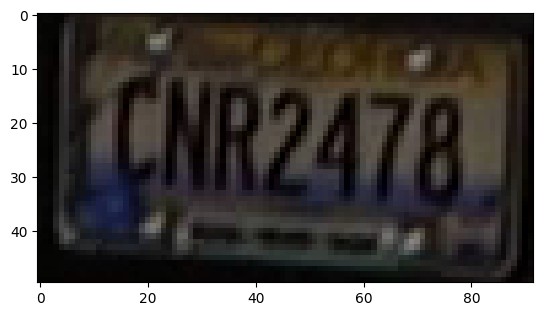

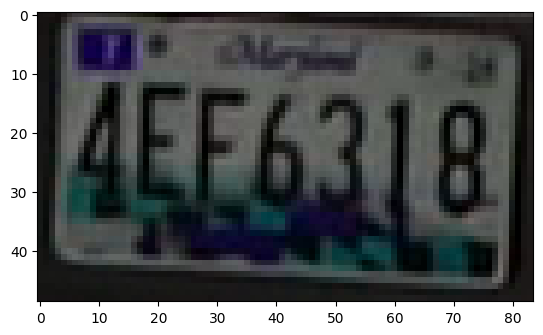

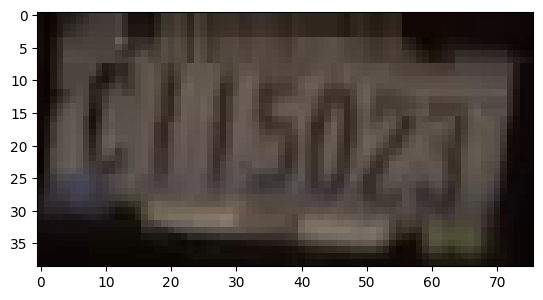

In [32]:
from ipywidgets import Video, Image
input_path = "1.mp4"
dataframe = response.batch.frames
car_plates = annotate_video(dataframe, input_path)

In [54]:
cursor.execute("DROP UDF OCRExtractor;")
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS OCRExtractor
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
              scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'ocr_extractor.py';
      """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                        0
0  UDF OCRExtractor successfully dropped
@query_time: 0.01461055688560009
@status: ResponseStatus.SUCCESS
@batch: 
                                                       0
0  UDF OCRExtractor successfully added to the database.
@query_time: 2.3823798801749945


In [71]:
#for i, plates in enumerate(car_plates):
#    for j, plate in enumerate(plates):
i=0
j=0
file_name = "frame" + str(i)+ "_plate" + str(j) + ".png"
print(file_name)
cursor.execute('DROP TABLE IF EXISTS MyImages')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "' + file_name + '" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute("""SELECT OCRExtractor(data)
                FROM MyImages""")
response = cursor.fetch_all()
print(response)

frame0_plate0.png
@status: ResponseStatus.SUCCESS
@batch: 
                                       0
0  Table Successfully dropped: MyImages
@query_time: 0.024829884059727192
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.04875818686559796
@status: ResponseStatus.SUCCESS
@batch: 
   ocrextractor.labels                     ocrextractor.bboxes  \
0         [[c017726]]  [[[0, 7], [84, 7], [84, 46], [0, 46]]]   

     ocrextractor.scores  
0  [0.23887794246165342]  
@query_time: 4.641338018933311


In [83]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_image_ocr(detections, input_image_path, output_image_path):
    color1=(0, 255, 150)
    color2=(255, 49, 49)
    thickness=4

    frame_id = 0
    frame = cv2.imread(input_image_path)

    print(detections)
    plate_id = 0

    df = detections
    df = df[['ocrextractor.bboxes', 'ocrextractor.labels']][df.index == frame_id]

    if df.size:
        dfLst = df.values.tolist()
        for bbox, label in zip(dfLst[plate_id][0], dfLst[plate_id][1]):
            x1, y1, x2, y2 = bbox
            x1, y1, x2, y2 = int(x1[0]), int(x1[1]), int(x2[0]), int(x2[1])
            # object bbox
            frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
            # object label
            frame = cv2.putText(frame, label, (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 1, color2, thickness, cv2.LINE_AA) 

            # Show every  frame
            plt.imshow(frame)
            plt.show()

            cv2.imwrite(output_image_path, frame)


In [84]:
from ipywidgets import Image
input_path = 'frame0_plate0.png'
output_path = 'frame0_plate0.png'

  ocrextractor.labels                     ocrextractor.bboxes  \
0         [[c017726]]  [[[0, 7], [84, 7], [84, 46], [0, 46]]]   

     ocrextractor.scores  
0  [0.23887794246165342]  


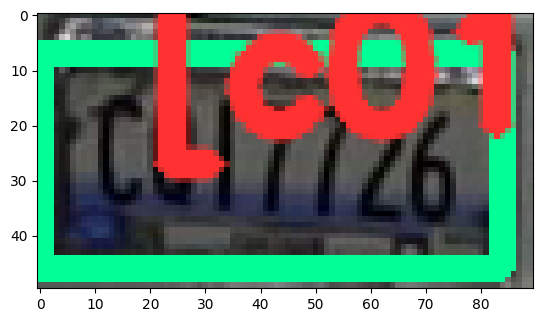

In [85]:
dataframe = response.batch.frames
annotate_image_ocr(dataframe, input_path, output_path)